In [1]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')
from scipy.cluster.hierarchy import ward, dendrogram
import seaborn as sns; 
sns.set()
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve,cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.dummy import DummyRegressor
from sklearn.metrics import accuracy_score,roc_curve,classification_report,confusion_matrix,precision_recall_curve,auc,f1_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the data. 
reviewdata=pd.read_csv('data/clean_up_data.csv')

In [4]:
reviewdata.head()

,star_rating,helpful_votes,total_votes,helpful_votes_ratio,review_length,arrange_product_id,arrange_product_title,arrange_product_parent,arrange_customer_id,product_title,review_body
0,5,0,0,0.000000,14,783255.0,696893.0,696055.0,1015876.0,"Scotch Cushion Wrap 7961, 12 Inches x 100 Feet",Great product.
1,5,0,1,0.000000,155,1964694.0,1881711.0,1885670.0,1801693.0,"Dust-Off Compressed Gas Duster, Pack of 4",What's to say about this commodity item except...
2,5,0,0,0.000000,47,554316.0,499073.0,500576.0,548574.0,Amram Tagger Standard Tag Attaching Tagging Gu...,"Haven't used yet, but I am sure I will like it."
3,1,2,3,0.666667,735,2150992.0,2099828.0,2103291.0,719312.0,AmazonBasics 12-Sheet High-Security Micro-Cut ...,Although this was labeled as &#34;new&#34; the...
4,4,0,0,0.000000,31,1460506.0,1848076.0,1845831.0,103335.0,"Derwent Colored Pencils, Inktense Ink Pencils,...",Gorgeous colors and easy to use


Before going to the modeling, let's use classified the reviews into two categories. This classification is motivated by the polarization of our reviews as indicated in our EDA step. We will label the review with no helpful votes or review with helpful_votes_ratio smaller than 0.5: 0.  The more helpful review with helpful_votes_ratio bigger than 0.5 as 1.

In [5]:
reviewdata['classified_review']=0

In [6]:
reviewdata.loc[reviewdata['helpful_votes_ratio']>0.5,'classified_review']=1

In [7]:
reviewdata.head()

,star_rating,helpful_votes,total_votes,helpful_votes_ratio,review_length,arrange_product_id,arrange_product_title,arrange_product_parent,arrange_customer_id,product_title,review_body,classified_review
0,5,0,0,0.000000,14,783255.0,696893.0,696055.0,1015876.0,"Scotch Cushion Wrap 7961, 12 Inches x 100 Feet",Great product.,0
1,5,0,1,0.000000,155,1964694.0,1881711.0,1885670.0,1801693.0,"Dust-Off Compressed Gas Duster, Pack of 4",What's to say about this commodity item except...,0
2,5,0,0,0.000000,47,554316.0,499073.0,500576.0,548574.0,Amram Tagger Standard Tag Attaching Tagging Gu...,"Haven't used yet, but I am sure I will like it.",0
3,1,2,3,0.666667,735,2150992.0,2099828.0,2103291.0,719312.0,AmazonBasics 12-Sheet High-Security Micro-Cut ...,Although this was labeled as &#34;new&#34; the...,1
4,4,0,0,0.000000,31,1460506.0,1848076.0,1845831.0,103335.0,"Derwent Colored Pencils, Inktense Ink Pencils,...",Gorgeous colors and easy to use,0


We will create a TFIDF model for our classification. However, before doing that, we will need to tokenize and lemmatize our reviews to reduce the forms of many words such as zip, zipped, zipping etc. This will make our TFIDF more relevant.

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)

In [9]:
reviewdata['cleaned_review'] = reviewdata['review_body'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if word.lower() not in stop_words]))

Now we can create the TFIDF model. We will use the most 50 common words first. This number can be adjusted in the hyper-parameter search stage to optimize the model.

In [10]:
def clf_model(model_type, X_train, y_train, X_test):
    model = model_type.fit(X_train,y_train)
    predicted_labels = model.predict(X_test)
    predicted_probab = model.predict_proba(X_test)[:,1]
    return [predicted_labels,predicted_probab, model]

In [11]:
def model_evaluation(actual_values, predicted_values, predicted_probabilities):
    cfn_mat = confusion_matrix(actual_values,predicted_values,labels=[0, 1])
    print("confusion matrix: \n",cfn_mat)
    print("\naccuracy: ",accuracy_score(actual_values,predicted_values))
    print("\nclassification report: \n", classification_report(actual_values,predicted_values))
    # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     for i in range(3):
#         fpr[i], tpr[i], _ = roc_curve(actual_values[:, i], predicted_values[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
#     fpr["micro"], tpr["micro"], _ = roc_curve(actual_values.ravel(), predicted_values.ravel())
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    fpr,tpr,threshold=roc_curve(actual_values, predicted_probabilities)
    print ('\nArea under ROC curve for validation set:', auc(fpr,tpr))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fpr,tpr,label='Validation set AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend(loc='best')
    plt.show()
    return auc(fpr,tpr)

In [12]:
tfidf_model = TfidfVectorizer(max_features=50)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(reviewdata['cleaned_review']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,34,also,back,bought,br,buy,cartridge,color,easy,even,...,set,thing,time,use,used,using,well,work,would,year
0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.516693,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.760549,0.0,0.0,0.000000,0.0,0.0
3,0.66983,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.138623,0.0,0.0,0.194986,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.63401,0.597541,0.0,...,0.0,0.0,0.0,0.490893,0.000000,0.0,0.0,0.000000,0.0,0.0


Next, we will combine this model with important features from the original dataset such as review_length, star_ratings etc.

In [13]:
df2=reviewdata.drop(columns=['helpful_votes_ratio','classified_review','review_body','product_title','total_votes','helpful_votes','cleaned_review'])

In [14]:
df2=pd.concat([tfidf_df, df2], axis=1)

In [15]:
df2.head()

,34,also,back,bought,br,buy,cartridge,color,easy,even,...,well,work,would,year,star_rating,review_length,arrange_product_id,arrange_product_title,arrange_product_parent,arrange_customer_id
0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,5,14,783255.0,696893.0,696055.0,1015876.0
1,0.00000,0.0,0.0,0.0,0.516693,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,5,155,1964694.0,1881711.0,1885670.0,1801693.0
2,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,5,47,554316.0,499073.0,500576.0,548574.0
3,0.66983,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.194986,0.0,0.0,1,735,2150992.0,2099828.0,2103291.0,719312.0
4,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.63401,0.597541,0.0,...,0.0,0.000000,0.0,0.0,4,31,1460506.0,1848076.0,1845831.0,103335.0


In [51]:
X_train, X_test, y_train, y_test = train_test_split(df2, 
                                                    reviewdata.classified_review, test_size=0.3, 
                                                    random_state=47)

In [17]:
y_train.value_counts()

0    1182572
1     396515
Name: classified_review, dtype: int64

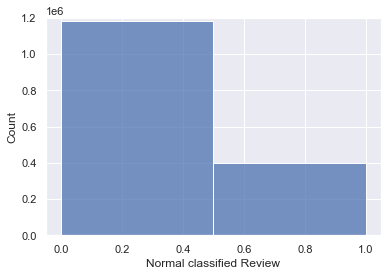

In [18]:
ax = sns.histplot(y_train, binwidth=0.5)
ax.set( xlabel='Normal classified Review')
plt.ylim([0,1200000])
plt.savefig("Classified_review_histogram_normal.png", bbox_inches="tight")
plt.show()

This shows that the reviews that are worthless dominate the whole data. To balance this, we will down-sample the bad review.

In [52]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_train.columns=df2.columns
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns=df2.columns
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [53]:
from sklearn.utils import resample
train_data = pd.concat([X_train, y_train], axis=1)
negative = train_data[train_data['classified_review']==0]
positive = train_data[train_data['classified_review']==1]
neg_downsampled = resample(negative,replace=True,n_samples=len(positive),random_state=21)
downsampled = pd.concat([positive, neg_downsampled])


In [54]:
y_train=downsampled.classified_review
X_train=downsampled.drop(columns='classified_review')

Now we can start modeling the training set. Let's first try Logistic Regression.

confusion matrix: 
 [[253943 253314]
 [ 84709  84786]]

accuracy:  0.5005216090975719

classification report: 
               precision    recall  f1-score   support

           0       0.75      0.50      0.60    507257
           1       0.25      0.50      0.33    169495

    accuracy                           0.50    676752
   macro avg       0.50      0.50      0.47    676752
weighted avg       0.62      0.50      0.53    676752


Area under ROC curve for validation set: 0.4991063006197509


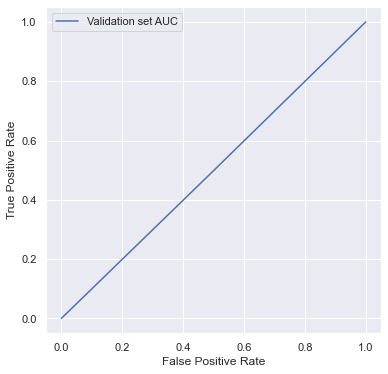

In [25]:
dcs = DummyClassifier(strategy='stratified')
results = clf_model(dcs, X_train, y_train, X_test)
dcs_accuracy=accuracy_score(y_test,results[0])
dcs_f1=f1_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_dcs=results[2]

confusion matrix: 
 [[360651 146606]
 [ 66791 102704]]

accuracy:  0.6846747405253327

classification report: 
               precision    recall  f1-score   support

           0       0.84      0.71      0.77    507257
           1       0.41      0.61      0.49    169495

    accuracy                           0.68    676752
   macro avg       0.63      0.66      0.63    676752
weighted avg       0.74      0.68      0.70    676752


Area under ROC curve for validation set: 0.7247705779175934


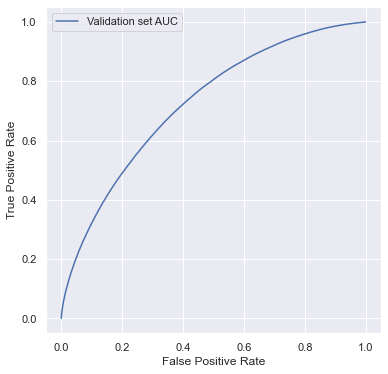

In [26]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
results = clf_model(logreg, X_train, y_train, X_test)
logreg_accuracy=accuracy_score(y_test,results[0])
logreg_f1=f1_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_logreg=results[2]

In [27]:
from sklearn.model_selection import cross_val_score

cv_scores_test= cross_val_score(logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.72038407 0.72187378 0.72327876 0.72186058 0.72163767]
Mean cross validation test score: 0.7218069724868458
Mean cross validation train score: 0.7264299718504004
Standard deviation in cv test scores: 0.0009194344516136567


Now, let's try RandomForest.

confusion matrix: 
 [[332057 175200]
 [ 55464 114031]]

accuracy:  0.6591602241293709

classification report: 
               precision    recall  f1-score   support

           0       0.86      0.65      0.74    507257
           1       0.39      0.67      0.50    169495

    accuracy                           0.66    676752
   macro avg       0.63      0.66      0.62    676752
weighted avg       0.74      0.66      0.68    676752


Area under ROC curve for validation set: 0.7244860698273822


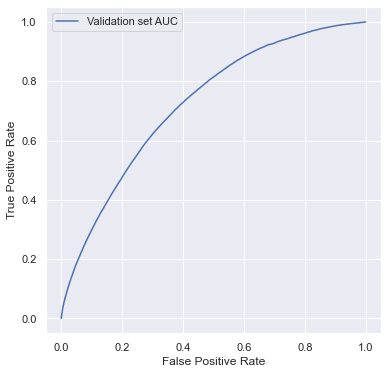

In [28]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier(n_estimators=20,max_depth=4,max_features='sqrt',random_state=1)
results = clf_model(rfc, X_train, y_train, X_test)
rfc_accuracy=accuracy_score(y_test,results[0])
rfc_f1=f1_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_rfc=results[2]

In [29]:
from sklearn.model_selection import cross_val_score

cv_scores_test= cross_val_score(rfc,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rfc,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rfc_test= cv_scores_test.mean()
cv_scores_rfc_train= cv_scores_train.mean()
cv_scores_std_test_rfc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rfc_test))
print ('Mean cross validation train score: ' +str(cv_scores_rfc_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_rfc))

[0.72485879 0.72545951 0.72424667 0.72335373 0.72396363]
Mean cross validation test score: 0.7243764669189676
Mean cross validation train score: 0.7268313853858956
Standard deviation in cv test scores: 0.0007264827639875706


In [30]:
word_importances = pd.DataFrame({'word':df2.columns,'importance':model_rfc.feature_importances_})
word_importances.sort_values('importance', ascending = False).head(20)

,word,importance
51,review_length,0.381755
26,one,0.098257
9,even,0.054728
43,use,0.047962
17,like,0.046129
11,get,0.043362
53,arrange_product_title,0.039600
48,would,0.039192
1,also,0.034393
52,arrange_product_id,0.030150


Let's try Gradient Bootsting.

[19:47:50] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix: 
 [[333910 173347]
 [ 52762 116733]]

accuracy:  0.6658909024280681

classification report: 
               precision    recall  f1-score   support

           0       0.86      0.66      0.75    507257
           1       0.40      0.69      0.51    169495

    accuracy                           0.67    676752
   macro avg       0.63      0.67      0.63    676752
weighted avg       0.75      0.67      0.69    676752


Area under ROC curve for validation set: 0.7396020195973956


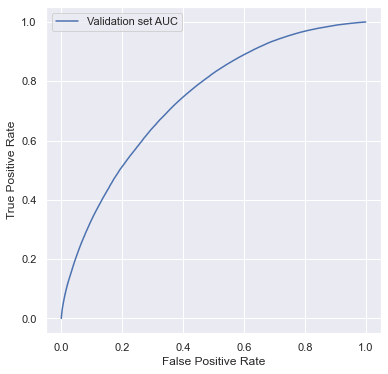

In [31]:
from xgboost import XGBClassifier
xgb_clf=XGBClassifier(n_estimators=20,learning_rate=0.03,max_depth=5,subsample=0.6,colsample_bytree= 0.6,reg_alpha= 10,seed=42)
results = clf_model(xgb_clf, X_train, y_train, X_test)
xgb_accuracy=accuracy_score(y_test,results[0])
xgb_f1=f1_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_xgb=results[2]

In [32]:
cv_scores_test= cross_val_score(xgb_clf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(xgb_clf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_xgb_test= cv_scores_test.mean()
cv_scores_xgb_train= cv_scores_train.mean()
cv_scores_std_test_xgb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_xgb_test))
print ('Mean cross validation train score: ' +str(cv_scores_xgb_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_xgb))

[19:47:59] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:48:04] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:48:08] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:48:13] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [33]:
word_importances = pd.DataFrame({'word':df2.columns,'importance':model_xgb.feature_importances_})
word_importances.sort_values('importance', ascending = False).head(20)

,word,importance
4,br,0.221614
51,review_length,0.218692
26,one,0.095787
14,great,0.047620
31,phone,0.040927
40,set,0.039575
43,use,0.038228
53,arrange_product_title,0.034232
33,print,0.032826
17,like,0.028759


Let's try Naive Bayes.

confusion matrix: 
 [[329219 178038]
 [ 69820  99675]]

accuracy:  0.6337535759037284

classification report: 
               precision    recall  f1-score   support

           0       0.83      0.65      0.73    507257
           1       0.36      0.59      0.45    169495

    accuracy                           0.63    676752
   macro avg       0.59      0.62      0.59    676752
weighted avg       0.71      0.63      0.66    676752


Area under ROC curve for validation set: 0.6639027596370204


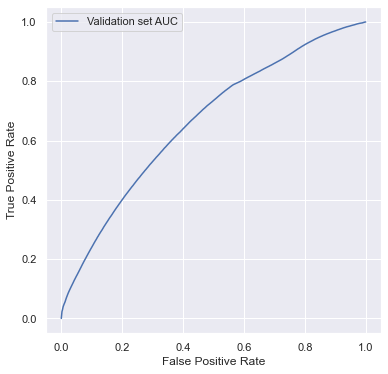

In [34]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
results = clf_model(nb, X_train, y_train, X_test)
nb_accuracy=accuracy_score(y_test,results[0])
nb_f1=f1_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_nb=results[2]

In [35]:
cv_scores_test= cross_val_score(nb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(nb,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_test_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_nb))

[0.66329955 0.66241527 0.66521584 0.66419945 0.66282541]
Mean cross validation test score: 0.663591105594663
Mean cross validation train score: 0.6656226335352939
Standard deviation in cv test scores: 0.001006353781577203


Let's try Linear Discriminant Analysis.

confusion matrix: 
 [[338248 169009]
 [ 62322 107173]]

accuracy:  0.6581746341348086

classification report: 
               precision    recall  f1-score   support

           0       0.84      0.67      0.75    507257
           1       0.39      0.63      0.48    169495

    accuracy                           0.66    676752
   macro avg       0.62      0.65      0.61    676752
weighted avg       0.73      0.66      0.68    676752


Area under ROC curve for validation set: 0.7084693525043793


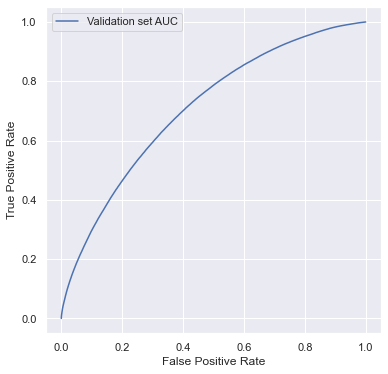

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()
results = clf_model(LDA, X_train, y_train, X_test)
LDA_accuracy=accuracy_score(y_test,results[0])
LDA_f1=f1_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_LDA=results[2]

In [37]:
cv_scores_test= cross_val_score(LDA,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(LDA,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_LDA_test= cv_scores_test.mean()
cv_scores_LDA_train= cv_scores_train.mean()
cv_scores_std_test_LDA= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_LDA_test))
print ('Mean cross validation train score: ' +str(cv_scores_LDA_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_LDA))

[0.71606999 0.71718032 0.7195546  0.71761434 0.71736058]
Mean cross validation test score: 0.7175559658615499
Mean cross validation train score: 0.7103228885116681
Standard deviation in cv test scores: 0.0011300769414217889


Let's compare the model performance on the test set.

In [38]:
modelLabels = [ 'Dummy Regression', 'Logistic Regression','Random Forest','Gradient Boost', 'Naive Bayes','Linear Discriminant Analysis']
score_test= [cv_scores_lr_test,cv_scores_rfc_test,cv_scores_xgb_test,cv_scores_nb_test,cv_scores_LDA_test]
score_train= [cv_scores_lr_train,cv_scores_rfc_train,cv_scores_xgb_train,cv_scores_nb_train,cv_scores_LDA_train]
accucracy_test= [dcs_accuracy,logreg_accuracy,rfc_accuracy,xgb_accuracy,nb_accuracy,LDA_accuracy]
f1_test= [dcs_f1,logreg_f1,rfc_f1,xgb_f1,nb_f1,LDA_f1]
score_tab = pd.DataFrame(list(zip(modelLabels, accucracy_test, f1_test)), 
               columns =['Algorithm', 'Accucracy', 'F1 score' ]) 

score_tab

,Algorithm,Accucracy,F1 score
0,Dummy Regression,0.500522,0.334069
1,Logistic Regression,0.684675,0.490462
2,Random Forest,0.659160,0.497164
3,Gradient Boost,0.665891,0.508004
4,Naive Bayes,0.633754,0.445766
5,Linear Discriminant Analysis,0.658175,0.480945


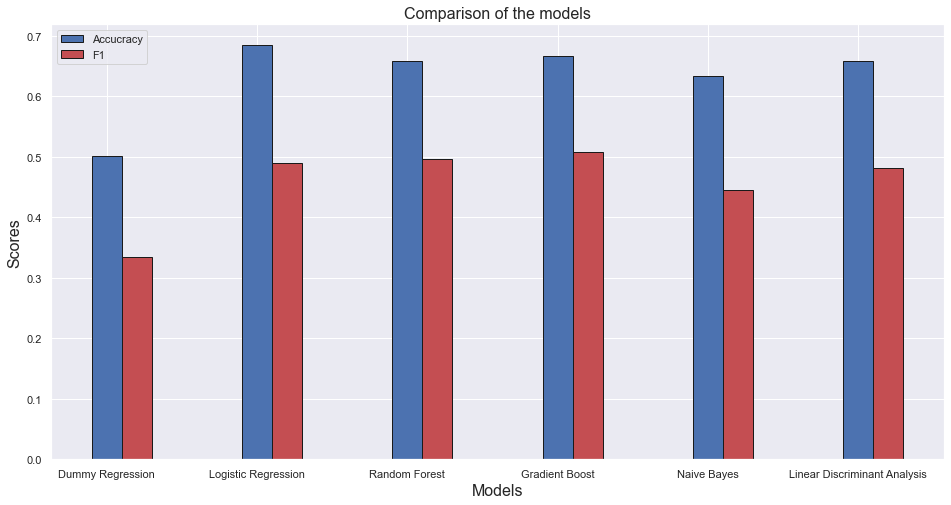

In [39]:
index1=[1,2,3,4,5,6]
index2=[1.2,2.2,3.2,4.2,5.2,6.2]
plt.figure(figsize=(16,8))
plt.xlabel('Models',fontsize=16)
plt.ylabel ('Scores',fontsize=16)
plt.title('Comparison of the models',fontsize=16)
_=plt.bar(index1,accucracy_test,color='b',label='Accucracy',edgecolor='k',width=0.2)
_=plt.bar(index2,f1_test,color='r',label='F1',edgecolor='k',width=0.2)
plt.xticks([1,2,3,4,5,6], modelLabels)
plt.legend()
plt.savefig("ModelCompare.png")
plt.show()

According to this, gradient boost is the best model. Next, let's optimize this model with a GridSearchCV. 

In [55]:
GB = XGBClassifier()
gb_param = {
        'n_estimators' : [20,40,60],
        'learning_rate': [0.1, 0.03],
        'max_depth': [5,10],
        'subsample': [0.6],
        'colsample_bytree': [0.6] ,
        'reg_alpha':[0,1]
        }

gsGB = GridSearchCV(GB, param_grid = gb_param, cv=2, scoring="roc_auc", n_jobs= -1, verbose = 1)
gsGB.fit(X_train,y_train)
print(gsGB.best_estimator_)
print(gsGB.best_score_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  5.3min finished


[20:08:08] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)
0.7524534191135238


[20:08:49] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix: 
 [[330057 177200]
 [ 48777 120718]]

accuracy:  0.6660859517223444

classification report: 
               precision    recall  f1-score   support

           0       0.87      0.65      0.74    507257
           1       0.41      0.71      0.52    169495

    accuracy                           0.67    676752
   macro avg       0.64      0.68      0.63    676752
weighted avg       0.75      0.67      0.69    676752


Area under ROC curve for validation set: 0.7505762600357024


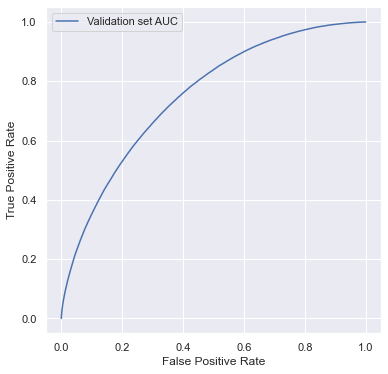

In [56]:
xgb_clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)
results = clf_model(xgb_clf, X_train, y_train, X_test)
xgb_accuracy=accuracy_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_xgb=results[2]

In [57]:
reviewdata['review_body'].head()

0                                       Great product.
1    What's to say about this commodity item except...
2      Haven't used yet, but I am sure I will like it.
3    Although this was labeled as &#34;new&#34; the...
4                      Gorgeous colors and easy to use
Name: review_body, dtype: object

In [58]:
review_train, review_test, reviewy_train, reviewy_test = train_test_split(reviewdata.review_body, 
                                                    reviewdata.classified_review, test_size=0.3, 
                                                    random_state=47)

In [59]:
target = pd.Series(xgb_clf.predict(X_test))
review_content = pd.Series(review_test)

output = pd.DataFrame(list(zip(review_content, target)), 
               columns =['Reviews content', 'Reviews helpful prediction']) 




output.to_csv('final_result_review.csv', index=False, header=True)

In [60]:
from xgboost import __version__ as xgboost_version

In [61]:
best_model = gsGB.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.xgboost_version = xgboost_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [62]:
from library.sb_utils import save_file
modelpath = '../models'
save_file(best_model, 'Amazon_Office_Product_Helpful_Review_Classification.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models\Amazon_Office_Product_Helpful_Review_Classification.pkl"


# Summary: 

In this project, we have created a model to predict how useful a review is on Amazon Office Product. Because of the polarization of the reviews, we label the more helpful review as 1 with the rest as 0. Next, we consider a TFIDF model with 50 features and externals features such as the review_length, arrange_product_title etc. Next, we fit the training data with the following models: 'Logistic Regression','Random Forest','Gradient Boost', 'Naive Bayes','Linear Discriminant Analysis'. We choose the roc_auc and the recall number as metrics instead of accucracy for our evaluations because the number of useless review is much bigger than the helpful ones. With these settings, the best model is 'Gradient Boost'. We then do a GridSearchCV to find the best parameters for our model. This optimized model gives an accucravy of 0.66 and a ROC_AUC curve of 0.75.

# Future Directions:

More advanced algorithms such as recurrent neural networks. 

More features such as prices and the number of people who buy the product. 

Token the reviews with bi-gram and tri-gram.